In [36]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn as sns
from IPython.display import Image, display

In [37]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures



In [38]:
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
# djf_dict mam_dict djfmam_dict
ssn = 'mam'
ar_dict = config[ssn]

In [39]:
# PDO monthly index
df = pd.read_csv(path_to_data+'teleconnection_indices/NOAA_PDO_index.csv',
                 engine='python', skiprows=1)
df['date'] = pd.date_range('1854-01', '2020-07', freq='MS')
df = df.set_index('date')
df = df.loc[(df.index.year >= 1979) & (df.index.year <= 2018)]

df['PDOCOND'] = df['Value']
df.loc[df['Value']>0, 'PDOCOND'] = 1
df.loc[df['Value']< 0, 'PDOCOND'] = 0
df

# # Trim date range
idx = (df.index >= ar_dict['start_date']) & (df.index <= ar_dict['end_date'])
PDOdf = df.loc[idx]
PDOdf
# # select months of season
# df_djf = df.loc[(df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2)]

,Date,Value,PDOCOND
date,,,
1979-03-01,197903,-0.68,0.0
1979-04-01,197904,-0.12,0.0
1979-05-01,197905,0.57,1.0
1979-06-01,197906,0.22,1.0
1979-07-01,197907,0.30,1.0
...,...,...,...
2018-01-01,201801,0.40,1.0
2018-02-01,201802,-0.07,0.0
2018-03-01,201803,-0.71,0.0


,YEAR,MON,DAY,ANOM,COND
date,,,,,
1979-03-01 09:00:00,1979,3,1,0.372,POSITIVE
1979-03-02 09:00:00,1979,3,2,0.737,POSITIVE
1979-03-03 09:00:00,1979,3,3,1.127,POSITIVE
1979-03-04 09:00:00,1979,3,4,1.264,POSITIVE
1979-03-05 09:00:00,1979,3,5,1.414,POSITIVE
...,...,...,...,...,...
2018-05-26 09:00:00,2018,5,26,0.597,POSITIVE
2018-05-27 09:00:00,2018,5,27,0.861,POSITIVE
2018-05-28 09:00:00,2018,5,28,1.036,POSITIVE


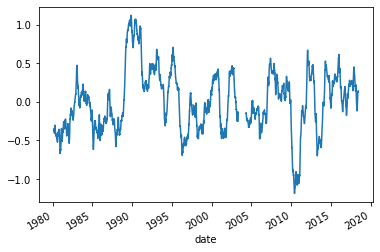

In [40]:
## AO
ref = 'daily'

fname_daily = 'teleconnection_indices/norm.daily.ao.index.b500101.current.ascii'
fname_monthly = 'teleconnection_indices/AO_CPC_NOAA_monthly_index_1950_2019.txt'

if ref == 'monthly':
    names=['year', 'month', 'anom']
    df = pd.read_csv(path_to_data + fname_monthly,
                    delim_whitespace=True, engine='python', header=0, names=names)

    df['3_month_running'] = df.loc[:,'anom'].rolling(window=3).mean()
    df['COND'] = 'NEUTRAL'
    df.loc[df['3_month_running']>0, 'COND'] = 'POSITIVE'
    df.loc[df['3_month_running']<0, 'COND'] = 'NEGATIVE'
    df = df.loc[(df['year'] >= 1980) & (df['year'] <= 2018)]
    AO_df = df.loc[(df['month'] == 12) | (df['month'] == 3) | (df['month'] == 6) | (df['month'] == 9)]
    
if ref == 'daily':
    names=['YEAR', 'MON', 'DAY', 'ANOM']
    df = pd.read_csv(path_to_data + fname_daily,
                    delim_whitespace=True, engine='python', header=0, names=names)
    
    df['COND'] = 'NEUTRAL'
    df.loc[df['ANOM']>0, 'COND'] = 'POSITIVE'
    df.loc[df['ANOM']<0, 'COND'] = 'NEGATIVE'
    df['date'] = pd.date_range('1950-01-02 9:00:00', '2019-02-28 9:00:00', freq='1D')
    df = df.set_index('date')
    
    # Trim date range
    idx = (df.index >= ar_dict['start_date']) & (df.index <= ar_dict['end_date'])
    df = df.loc[idx]
    df.ANOM.rolling(365).mean().plot()
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (df.MON >= ar_dict['mon_s']) | (df.MON <= ar_dict['mon_e'])
    else:
        idx = (df.MON >= ar_dict['mon_s']) & (df.MON <= ar_dict['mon_e'])

    df = df.loc[idx]

df

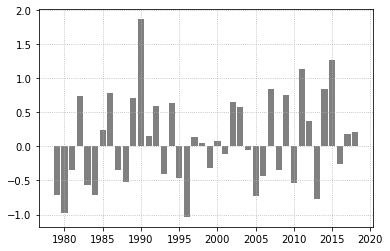

In [41]:
## resamples data to quarterly
df_ao = df.ANOM.resample('QS-DEC').mean()
df_ao = df_ao.dropna()
# df_ao = df_ao.rolling(5).mean()
# df_ao.plot()
df_ao.index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(1979,2019), df_ao.values, color='grey')
plt.grid(linestyle='dotted')

In [42]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-' + ssn + '.csv'
df = pd.read_csv(filepath)

# set up datetime index
df['DATE'] = pd.to_datetime(df['Unnamed: 0'])
dates = df.DATE.values
df = df.drop(columns=['Unnamed: 0'])
df = df.set_index('DATE')

df

,AR_CAT
DATE,
1979-03-01 09:00:00,0
1979-03-02 09:00:00,0
1979-03-03 09:00:00,0
1979-03-04 09:00:00,0
1979-03-05 09:00:00,0
...,...
2018-05-27 09:00:00,0
2018-05-28 09:00:00,0
2018-05-29 09:00:00,0


In [43]:
## Total typecount (1979-2018)

artypes = df.AR_CAT.values
typelist = [1, 2, 3]
ntypes = len(typelist)

# method 1
type_count1 = df['AR_CAT'].value_counts()
print(type_count1)

# method 2
type_count2 = np.empty(ntypes, dtype=int)
for k, cat in enumerate(typelist):
    idx = (artypes == cat)
    tmp = artypes[idx]
    type_count2[k] = len(tmp) 
    print(cat, type_count2[k])

# percentages
totdays = np.sum(type_count2)
type_freq = type_count2 / totdays
print(type_freq*100)


0    3239
1     154
2     146
3     141
Name: AR_CAT, dtype: int64
1 154
2 146
3 141
[34.92063492 33.10657596 31.97278912]


In [44]:
## Count number of each AR type per year

years = np.arange(1979, 2019)   # list of years
nyrs = len(years)-1               # number of years
typecount_per_yr = np.empty((nyrs,ntypes))

# Loop to count and tag AR events each year
for i in range(nyrs):
    # index first and last day of season
    start_date = pd.to_datetime("{0}-{1}-{2} 9:00".format(years[i], ar_dict['mon_s'], ar_dict['day_s']))
    end_date = pd.to_datetime("{0}-{1}-{2} 9:00".format(years[i+1], ar_dict['mon_e'], ar_dict['day_e']))
    # select rows by date using df.loc[start_date:end_date]
    tmp = df.loc[start_date:end_date]
    # extract ar time series
    x = tmp['AR_CAT'].values
    
    # loop to count frequency of each AR type
    for j, cat in enumerate(typelist):
        idx = (x == cat)
        tmp = x[idx]
        typecount_per_yr[i,j] = len(tmp)
        

In [45]:
# Convert annual counts of each type from array to pd dataframe

data = {'years':years[0:-1],
        'ar_type1': typecount_per_yr[:,0],
        'ar_type2': typecount_per_yr[:,1],
        'ar_type3': typecount_per_yr[:,2]}

df_ann= pd.DataFrame(data)
df_ann['ar_typeall'] = df_ann['ar_type1'] + df_ann['ar_type2'] + df_ann['ar_type3']
# df_ann
df_ann.describe()

,years,ar_type1,ar_type2,ar_type3,ar_typeall
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,1998.000000,7.769231,7.333333,7.179487,22.282051
std,11.401754,3.828299,3.665869,4.315650,7.236416
min,1979.000000,0.000000,1.000000,0.000000,9.000000
25%,1988.500000,5.000000,4.500000,4.000000,17.000000
50%,1998.000000,7.000000,7.000000,7.000000,21.000000
75%,2007.500000,10.000000,10.000000,9.000000,28.000000
max,2017.000000,19.000000,15.000000,21.000000,36.000000


In [46]:
# combine ar annual df with ao annual df
df_ann
df_ao

date
1979-03-01   -0.709761
1980-03-01   -0.972946
1981-03-01   -0.340880
1982-03-01    0.738337
1983-03-01   -0.559739
1984-03-01   -0.708946
1985-03-01    0.243826
1986-03-01    0.778957
1987-03-01   -0.340272
1988-03-01   -0.515446
1989-03-01    0.707337
1990-03-01    1.868815
1991-03-01    0.153522
1992-03-01    0.591989
1993-03-01   -0.411022
1994-03-01    0.644380
1995-03-01   -0.464783
1996-03-01   -1.035326
1997-03-01    0.143859
1998-03-01    0.044630
1999-03-01   -0.321989
2000-03-01    0.080587
2001-03-01   -0.116391
2002-03-01    0.658804
2003-03-01    0.576571
2004-03-01   -0.056098
2005-03-01   -0.734054
2006-03-01   -0.433457
2007-03-01    0.849196
2008-03-01   -0.344402
2009-03-01    0.754598
2010-03-01   -0.535446
2011-03-01    1.140217
2012-03-01    0.380783
2013-03-01   -0.773359
2014-03-01    0.840033
2015-03-01    1.265489
2016-03-01   -0.251185
2017-03-01    0.184511
2018-03-01    0.214044
Name: ANOM, dtype: float64

In [47]:
if ssn == 'djf':
    df_ann['AO_ANOM'] = df_ao.values
elif ssn == 'mam':
    df_ann['AO_ANOM'] = df_ao.values[:-1]
df_ann

,years,ar_type1,ar_type2,ar_type3,ar_typeall,AO_ANOM
0,1979,7.0,7.0,3.0,17.0,-0.709761
1,1980,8.0,4.0,8.0,20.0,-0.972946
2,1981,6.0,2.0,8.0,16.0,-0.340880
3,1982,4.0,10.0,5.0,19.0,0.738337
4,1983,7.0,9.0,5.0,21.0,-0.559739
5,1984,7.0,2.0,3.0,12.0,-0.708946
6,1985,9.0,6.0,1.0,16.0,0.243826
7,1986,10.0,8.0,6.0,24.0,0.778957
8,1987,10.0,8.0,7.0,25.0,-0.340272
9,1988,13.0,11.0,5.0,29.0,-0.515446


In [48]:
# melt to do one plot with ar type as hue
df1 = pd.melt(df_ann, id_vars=['years'], var_name='ar_type', value_name='frequency')
df1

,years,ar_type,frequency
0,1979,ar_type1,7.000000
1,1980,ar_type1,8.000000
2,1981,ar_type1,6.000000
3,1982,ar_type1,4.000000
4,1983,ar_type1,7.000000
...,...,...,...
190,2013,AO_ANOM,-0.773359
191,2014,AO_ANOM,0.840033
192,2015,AO_ANOM,1.265489
193,2016,AO_ANOM,-0.251185


<Figure size 432x288 with 0 Axes>

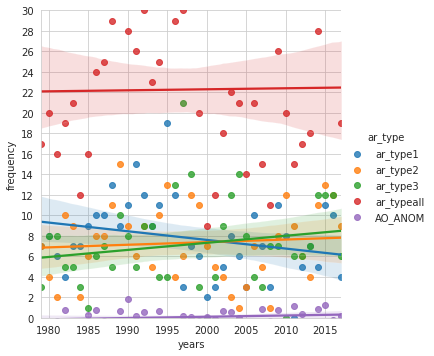

In [49]:
# set seaborn style
          
sns.set_style("whitegrid")
sns.despine()
#sns.set_style("ticks", {'patch.force_edgecolor':False})
# plot time series

sns_plot = sns.lmplot(x='years',y='frequency', hue='ar_type', data=df1)
yticks=np.arange(0,32,2)
plt.ylim(0,30)
plt.yticks(yticks)

outfile = path_to_figs + 'artype_trends_' + ssn + '.png'
sns_plot.savefig(outfile)


In [50]:
data_roll = df_ann.rolling(5).mean()
data_roll
sns.set(style = 'whitegrid') 
# melt to do one plot with ar type as hue
df1_roll = pd.melt(data_roll, id_vars=['years'], var_name='ar_type', value_name='frequency')


/home/nash/DATA/repositories/AR_types/figs/artype_5yrmean_mam.png


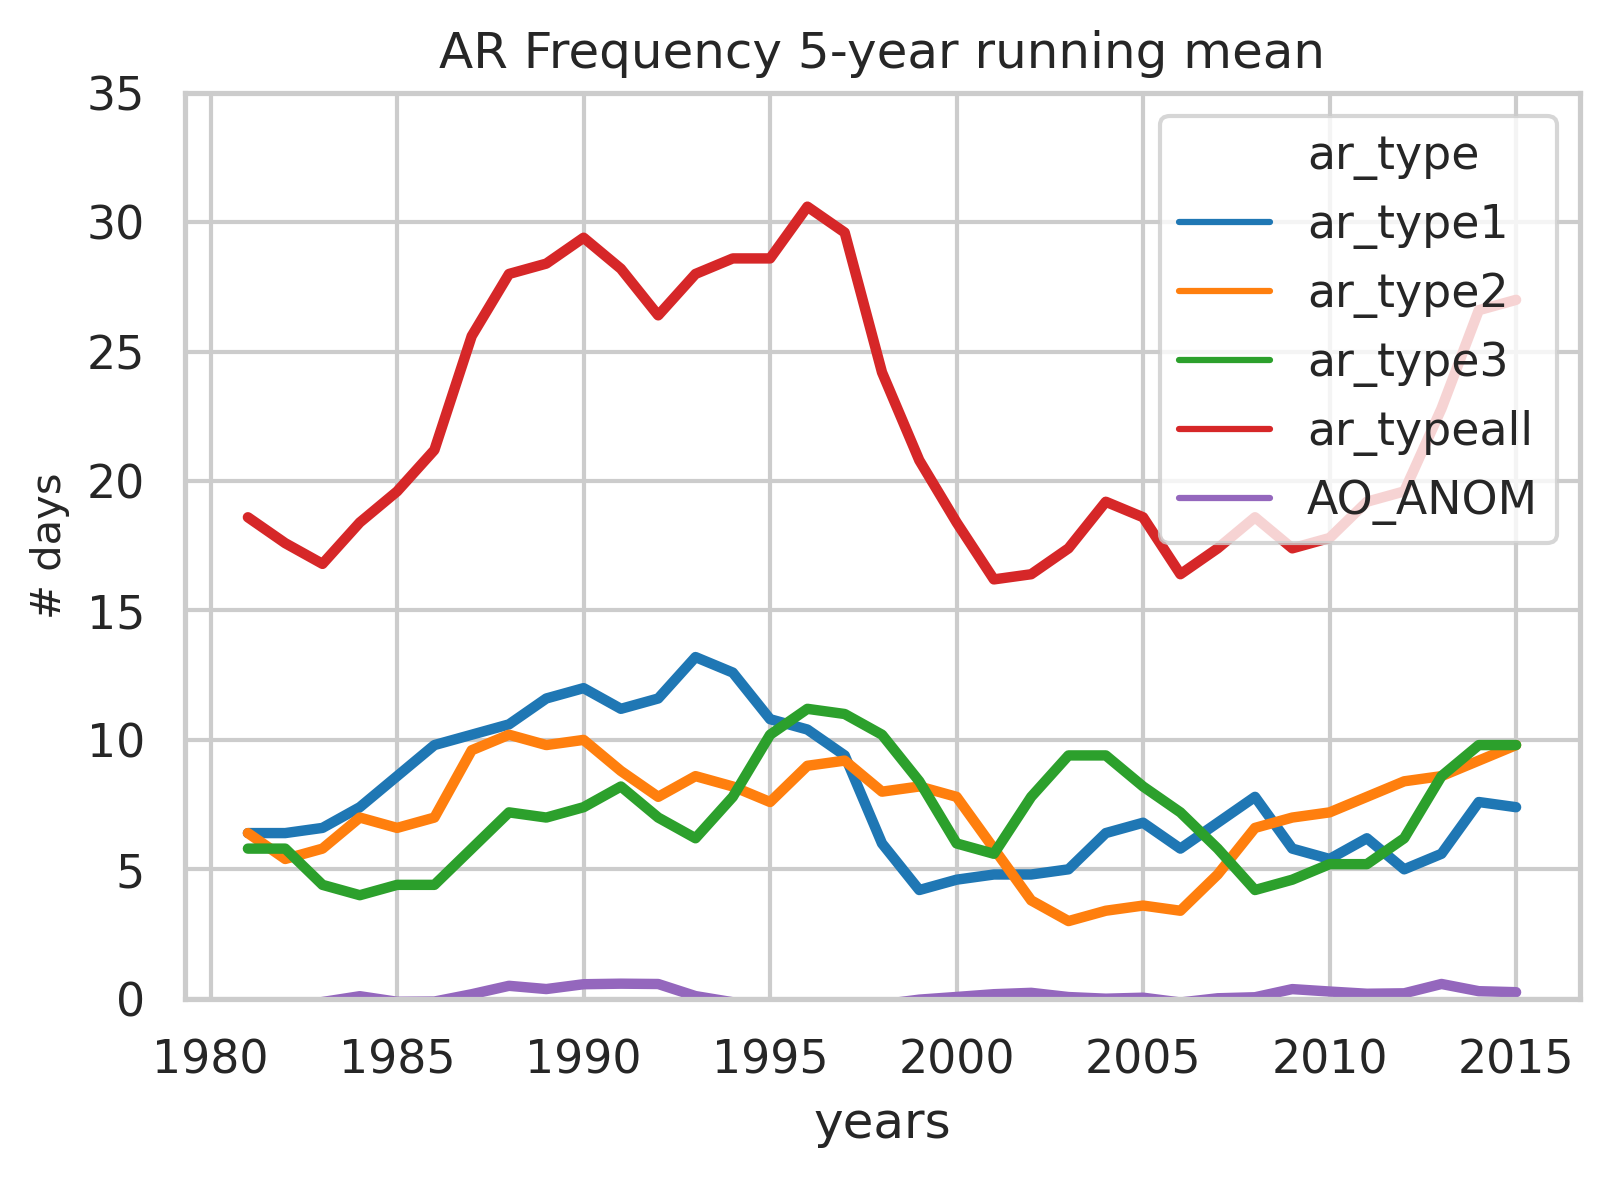

<Figure size 1800x1200 with 0 Axes>

In [51]:
outfile = path_to_figs + 'artype_5yrmean_' + ssn + '.png'
fig = plt.figure()
# fig.set_size_inches((12.0,3.0))
fig.dpi = 300
nplots=1
          
sns.set_style("whitegrid")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.lineplot(x='years',y='frequency', hue='ar_type', data=df1_roll, palette="tab10", linewidth=2.5, ci='sd')
    ax.set_title('AR Frequency 5-year running mean', fontsize=12)
    ax.set_ylabel('# days', fontsize=10)
    ax.legend(loc='upper right')
    plt.ylim(0,35)
    
# Save the figure
fig.savefig(outfile, bbox_inches='tight', dpi=fig.dpi)
fig.clf()

print(outfile)
display(Image(outfile))

/home/nash/DATA/repositories/AR_types/figs/artype_ao_5yrmean_mam.png


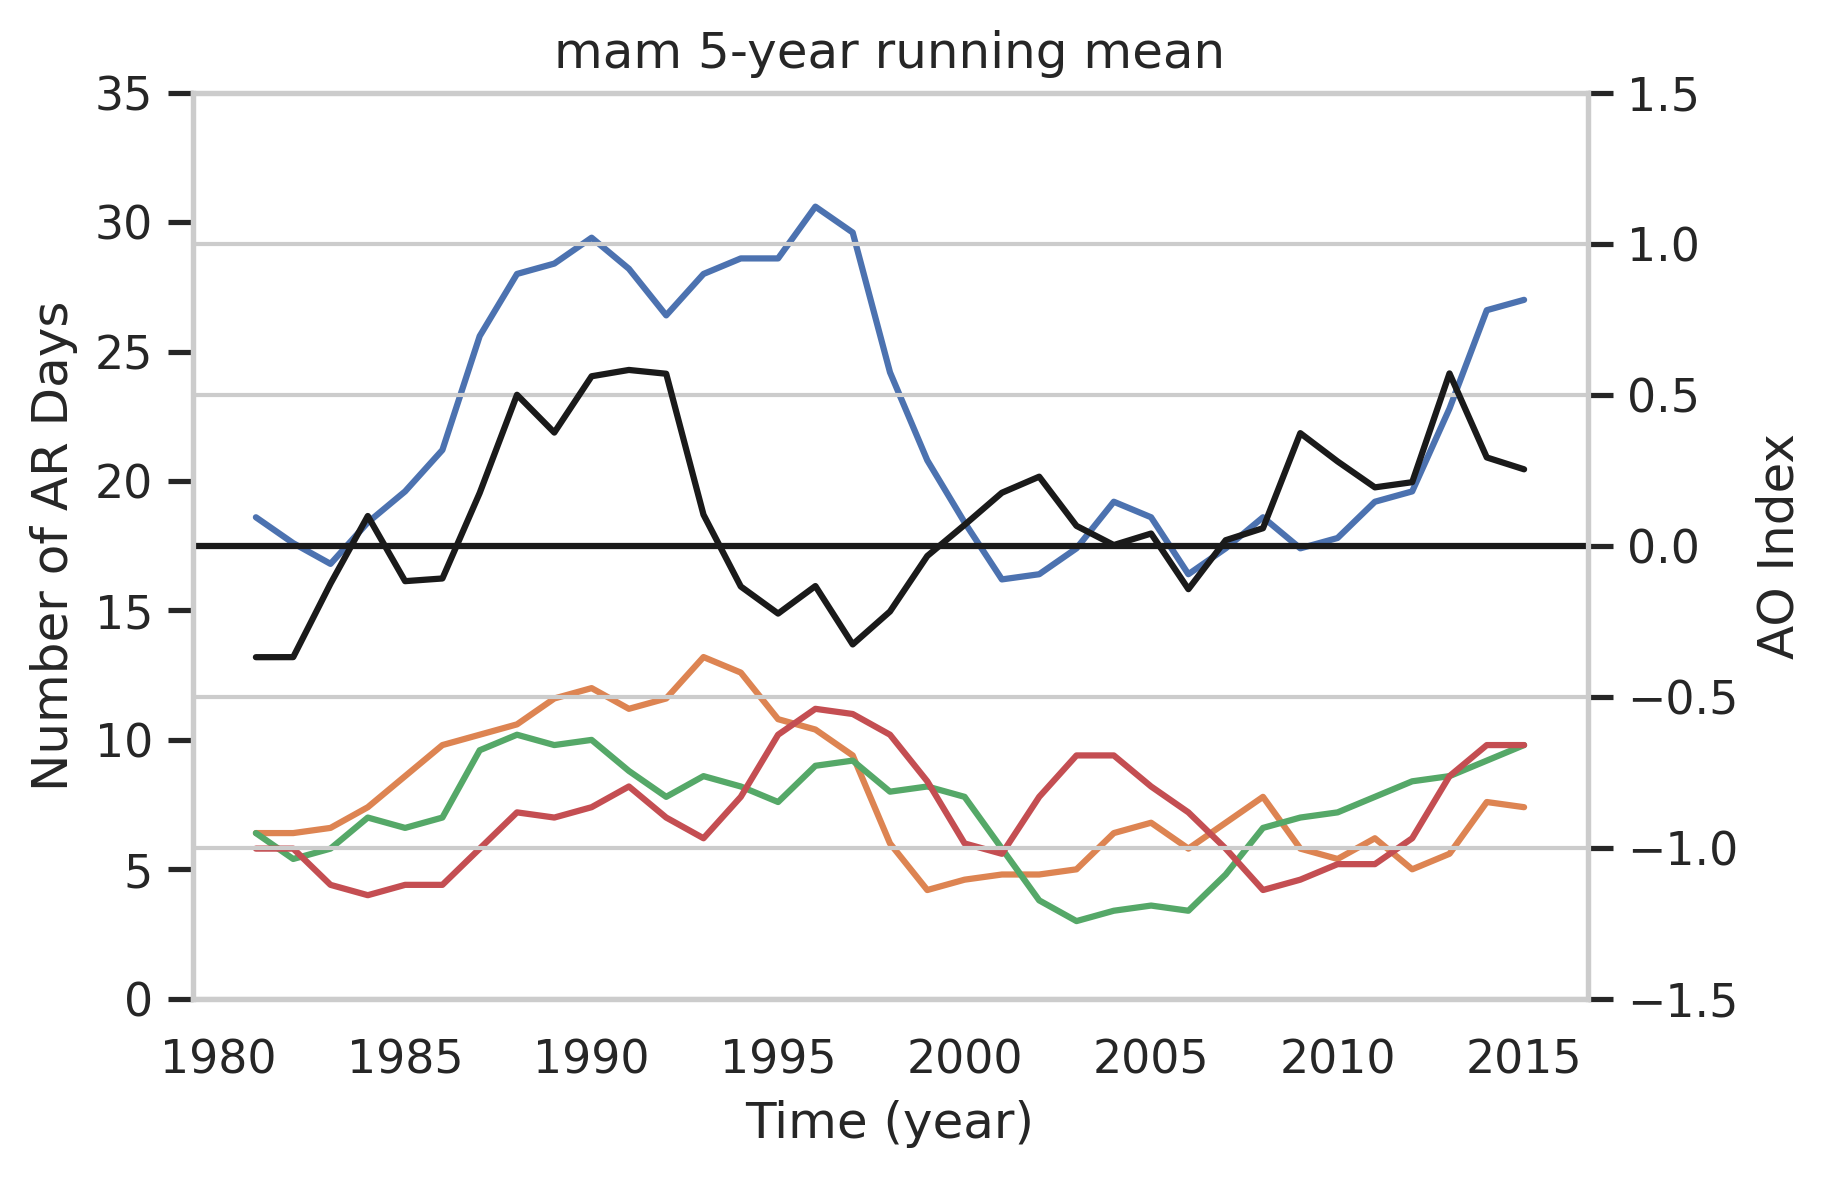

<Figure size 1800x1200 with 0 Axes>

In [52]:
# data to plot
time = data_roll.years
ar_all = data_roll.ar_typeall
ar_1 = data_roll.ar_type1
ar_2 = data_roll.ar_type2
ar_3 = data_roll.ar_type3
ao = data_roll.AO_ANOM

# set up figure
outfile = path_to_figs + 'artype_ao_5yrmean_' + ssn + '.png'
fig = plt.figure()
# fig.set_size_inches((12.0,3.0))
fig.dpi = 300

ax = fig.add_subplot(111)
# lines on left axis
lns1 = ax.plot(time, ar_all, label='AR Type all')
lns2 = ax.plot(time, ar_1, label='AR Type 1')
lns3 = ax.plot(time, ar_2, label='AR Type 2')
lns4 = ax.plot(time, ar_3, label='AR Type 3')
ax.grid(False)
# lines on right axis
ax2 = ax.twinx()
lns5 = ax2.plot(time, ao, color="k", label='AO Index')
ax2.axhline(0, color='k')

# legend for all lines
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, frameon=False, loc='lower center', ncol=5)

# labels
ax.set_xlabel("Time (year)")
ax.set_ylabel(r"Number of AR Days")
ax2.set_ylabel(r"AO Index")
ax2.set_ylim(-1.5, 1.5)
ax.set_ylim(0,35)
plt.title(ssn+' 5-year running mean')

# Save the figure
fig.savefig(outfile, bbox_inches='tight', dpi=fig.dpi)
fig.clf()

print(outfile)
display(Image(outfile))